In [16]:
import chess
import chess.engine
import chess.pgn
import random
import numpy as np
# Creates a Random Board
def random_board(max_depth=12):
  board = chess.Board()
  depth = random.randrange(0, max_depth)
  for _ in range(depth):
    all_moves = list(board.legal_moves)
    random_move = random.choice(all_moves)
    board.push(random_move)
    if board.is_game_over():
      break
  return board
# Gives score to position of white. Checks steps ahead by using depth.
def stockfish(board, depth):
  with chess.engine.SimpleEngine.popen_uci('C:/Users/Mohamed - Khadar/Documents/stockfish_14.1_win_x64_avx2/stockfish_14.1_win_x64_avx2') as sf:
    result = sf.analyse(board, chess.engine.Limit(depth=depth))
    score = result['score'].white().score()
    return score

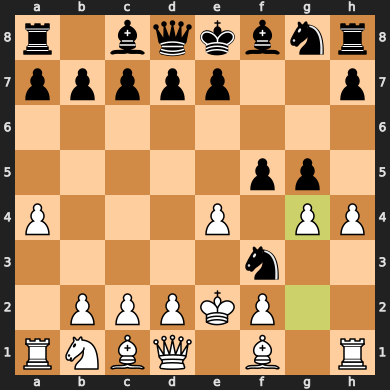

In [17]:
board = random_board()
board

In [18]:
stockfish(board, 10)

-885

In [19]:
squares_index = {
  'a': 0,
  'b': 1,
  'c': 2,
  'd': 3,
  'e': 4,
  'f': 5,
  'g': 6,
  'h': 7
}


# example: h3 -> 17
def square_to_index(square):
  letter = chess.square_name(square)
  return 8 - int(letter[1]), squares_index[letter[0]]


def split_dims(board):
  # this is the 3d matrix
  board3d = np.zeros((14, 8, 8), dtype=np.int8)

  # here we add the pieces's view on the matrix
  for piece in chess.PIECE_TYPES:
    for square in board.pieces(piece, chess.WHITE):
      idx = np.unravel_index(square, (8, 8))
      board3d[piece - 1][7 - idx[0]][idx[1]] = 1
    for square in board.pieces(piece, chess.BLACK):
      idx = np.unravel_index(square, (8, 8))
      board3d[piece + 5][7 - idx[0]][idx[1]] = 1

  # add attacks and valid moves too
  # so the network knows what is being attacked
  aux = board.turn
  board.turn = chess.WHITE
  for move in board.legal_moves:
      i, j = square_to_index(move.to_square)
      board3d[12][i][j] = 1
  board.turn = chess.BLACK
  for move in board.legal_moves:
      i, j = square_to_index(move.to_square)
      board3d[13][i][j] = 1
  board.turn = aux

  return board3d
split_dims(board)

array([[[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 1, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        

In [20]:
from tensorflow import keras

def build_model(conv_size, conv_depth):
  board3d = keras.layers.Input(shape=(14, 8, 8))
  x = board3d
  for _ in range(conv_depth):
    x = keras.layers.Conv2D(filters=conv_size, kernel_size=3,
    padding='same', activation='relu')(x)
  x = keras.layers.Flatten()(x)
  x = keras.layers.Dense(64, 'relu')(x)
  x = keras.layers.Dense(1, 'sigmoid')(x)
  return keras.models.Model(inputs=board3d, outputs=x)


In [21]:
model = build_model(32, 4)

In [22]:
def get_dataset():
	container = np.load('dataset.npz', allow_pickle=False)
	b, v = container['b'], container['v']
	v = np.asarray(v / abs(v).max() / 2 + 0.5, dtype=np.float32) # normalization (0 - 1)
	return b, v


x_train, y_train = get_dataset()
x_train.transpose()
print(x_train.shape)
print(y_train.shape)

(1500000, 14, 8, 8)
(1500000,)


In [23]:
#from keras.callbacks import ModelCheckpoint
#model.compile(optimizer=keras.optimizers.Adam(5e-4), loss='mean_squared_error')
#model.summary()
#checkpoint_filepath = '/tmp/checkpoint/'
#model_checkpointing_callback = ModelCheckpoint(
#    filepath = checkpoint_filepath,
#    save_best_only= True,
#)
#model.fit(x_train, y_train,
#          batch_size=2048,
#          epochs=10,
#          verbose=1,
#          validation_split=0.1,
#          callbacks=[keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=10),
#                     keras.callbacks.EarlyStopping(monitor='loss', patience=15, min_delta=1e-4),model_checkpointing_callback])
#
#model.save('model.h5')

In [24]:
model = keras.models.load_model('model.h5')

In [25]:
# returns score of board.
def minimax_eval(board):
  board3d = split_dims(board)
  board3d = np.expand_dims(board3d, 0)
  return model(board3d)[0][0]


def minimax(board, depth, alpha, beta, maximizing_player):
  if depth == 0 or board.is_game_over():
    return minimax_eval(board)
  
  if maximizing_player:
    max_eval = -np.inf
    for move in board.legal_moves:
      board.push(move)
      eval = minimax(board, depth - 1, alpha, beta, False)
      board.pop()
      max_eval = max(max_eval, eval)
      alpha = max(alpha, eval)
      if beta <= alpha:
        break
    return max_eval
  else:
    min_eval = np.inf
    for move in board.legal_moves:
      board.push(move)
      eval = minimax(board, depth - 1, alpha, beta, True)
      board.pop()
      min_eval = min(min_eval, eval)
      beta = min(beta, eval)
      if beta <= alpha:
        break
    return min_eval

# this is the actual function that gets the move from the neural network
# checks each move by using the model we created to give it a score. max_eval score starts at negative infinity. 
# eventually best score and move is recorded. the pop function sets back board 1 step since we give the board to the minimax().

def get_ai_move(board, depth):
  max_move = None
  max_eval = -np.inf

  for move in board.legal_moves:
    board.push(move)
    eval = minimax(board, depth - 1, -np.inf, np.inf, chess.WHITE)
    #print(eval)
    board.pop()
    if eval > max_eval:
      max_eval = eval
      max_move = move
  
  return max_move

In [27]:
game = chess.pgn.Game()
board = game.board()
from IPython.display import clear_output


with chess.engine.SimpleEngine.popen_uci('C:/Users/Mohamed - Khadar/Documents/stockfish_14.1_win_x64_avx2/stockfish_14.1_win_x64_avx2') as engine:
    for i in range(10000):
        if i == 0:
            res = get_ai_move(board, 4)
            move = chess.Move.from_uci(str(res))
            node = game.add_variation(move)
            board.push(move)
            print(f'\n AI:\n {board}')
            if board.is_game_over():
                print('game_over')
                break
            res = engine.analyse(board, chess.engine.Limit(time=0.1), info=chess.engine.INFO_PV)['pv'][0]
            move = chess.Move.from_uci(str(res))
            node = node.add_variation(move)
            board.push(move)
            print(f'\n Stockfish:\n {board}')
            if board.is_game_over():
                print('game_over')
                break
        else:
            res = get_ai_move(board, 4)
            move = chess.Move.from_uci(str(res))
            node = node.add_variation(move)
            board.push(move)
            print(f'\n AI:\n {board}')
            if board.is_game_over():
                print('game_over')
                break
            res = engine.analyse(board, chess.engine.Limit(time=0.1), info=chess.engine.INFO_PV)['pv'][0]
            move = chess.Move.from_uci(str(res))
            node = node.add_variation(move)
            board.push(move)
            print(f'\n Stockfish:\n {board}')
            if board.is_game_over():
                print('game_over')
                break
    print(game)


#game.headers["Event"] = "Example"
#move = chess.Move.from_uci("e2e4")
#node = game.add_variation(move)
#node = node.add_variation(chess.Move.from_uci("e7e5"))
#board.push(move)
#print(game)
#print(board)



 AI:
 r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . P .
P P P P P P . P
R N B Q K B N R

 Stockfish:
 r n b q k b n r
p p p p . p p p
. . . . . . . .
. . . . p . . .
. . . . . . . .
. . . . . . P .
P P P P P P . P
R N B Q K B N R


KeyboardInterrupt: 